## Shape recognition 

In [1]:
import numpy as np
import json
import pickle


## Load training data

In [2]:
seq_length=100
img_size=20


def normalize_points(lpoints):
    p=np.array(lpoints)
    p=p-p.min(axis=0)
    return p/(p.max()+0.01)

def iter_training():
    for line in open("whiteboard/data/training.json"):
        obj=json.loads(line.strip())
        yield obj["shape"],obj["points"]

def iter_normalized():
    for shape,points in iter_training():
        if shape!="?" and len(points)>20:
            yield shape,normalize_points(points)

def iter_sequences(size):
    for shape,points in iter_normalized():
        seq=np.array(lpoints[:size])
        if len(lpoints)<size:
            seq=np.pad(seq,pad_width=( (0,size-len(lpoints)) , (0,0) ), mode="edge")
        yield shape,seq

hsymetry={"rectangle":"rectangle","elispse":"elispse",
          "leftbracket":"leftbracket","rightbracket":"rightbracket",
          "sigma":"sigma","leftarrow":"leftarrow","rightarrow":"rightarrow",
          "uparrow":"downarrow","downarrow":"uparrow",
          "hline":"hline","vline":"vline","upline":"downline","downline":"upline"}


vsymetry={"rectangle":"rectangle","elispse":"elispse","triangle":"triangle",
          "leftbracket":"rightbracket","rightbracket":"leftbracket",
          "leftarrow":"rightarrow","rightarrow":"leftarrow",
          "uparrow":"uparrow","downarrow":"downarrow",
          "hline":"hline","vline":"vline","upline":"downline","downline":"upline"}



def enrich_image(shape,img):
    yield shape,img
    
    #horizontal symetry
    if shape in hsymetry:
        yield hsymetry[shape],np.flipud(img)

    #vertical symetry
    if shape in vsymetry:
        yield vsymetry[shape],np.fliplr(img)

def iter_images():
    for shape,points in iter_normalized():
        img=np.zeros((img_size,img_size))
        for y,x in np.rollaxis(points, 0):
            img[int(x*img_size),int(y*img_size)]=1.0
        for shape1,img1 in enrich_image(shape,img):
            yield shape1,img1.reshape(img_size,img_size,1)


In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
X=np.array([p for _,p in iter_images() ])
X.shape

(2432, 20, 20, 1)

In [5]:
yLabel=[label for label,_ in iter_images() ]
labelEncoder=LabelEncoder().fit(yLabel)
num_classes=len(labelEncoder.classes_)
y=to_categorical(labelEncoder.transform(yLabel))
y.shape

(2432, 15)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [7]:
model=Sequential()
model.add(Conv2D(32, kernel_size=(4,4),activation='relu',input_shape=(img_size,img_size,1)))
#model.add(Conv2D(16, kernel_size=(3,3),activation='relu'))
model.add(Flatten())
model.add(Dropout(0.2)) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 17, 17, 32)        544       
_________________________________________________________________
flatten (Flatten)            (None, 9248)              0         
_________________________________________________________________
dropout (Dropout)            (None, 9248)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1183872   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1935      
Total params: 1,186,351
Trainable params: 1,186,351
Non-trainable params: 0
______________________________________________

In [8]:
model.compile(loss=categorical_crossentropy,optimizer=Adam(lr=0.001),metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=10, epochs=20,verbose=1, validation_data=(X_test,y_test))
score = model.evaluate(X_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
195/195 [==============================] - 2s 10ms/step - loss: 1.2853 - accuracy: 0.6247 - val_loss: 0.6287 - val_accuracy: 0.8480
Epoch 2/20
195/195 [==============================] - 2s 9ms/step - loss: 0.3822 - accuracy: 0.8987 - val_loss: 0.4660 - val_accuracy: 0.8932
Epoch 3/20
195/195 [==============================] - 2s 11ms/step - loss: 0.1857 - accuracy: 0.9506 - val_loss: 0.5185 - val_accuracy: 0.8747
Epoch 4/20
195/195 [==============================] - 2s 10ms/step - loss: 0.0966 - accuracy: 0.9769 - val_loss: 0.4197 - val_accuracy: 0.9158
Epoch 5/20
195/195 [==============================] - 2s 10ms/step - loss: 0.0651 - accuracy: 0.9835 - val_loss: 0.4346 - val_accuracy: 0.9138
Epoch 6/20
195/195 [==============================] - 2s 10ms/step - loss: 0.0471 - accuracy: 0.9918 - val_loss: 0.4390 - val_accuracy: 0.9138
Epoch 7/20
195/195 [==============================] - 2s 10ms/step - loss: 0.0399 - accuracy: 0.9907 - val_loss: 0.4444 - val_accuracy: 0.9138


In [9]:
import pandas as pd
df=pd.DataFrame(history.history)
df.plot(kind="line",subplots=(2,2),figsize=(10,10),layout=(2,2))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f95877128>,
      dtype=object)

In [10]:
modelDir="whiteboard/model"
model.save(modelDir)

pickle.dump(labelEncoder,open(modelDir+"/assets/labelEncoder.pickle","wb"))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: whiteboard/model/assets


In [11]:
import matplotlib.pyplot as plt

%matplotlib inline

In [12]:
predictions=model.predict(X)
predictedLabels=labelEncoder.inverse_transform(predictions.argmax(axis=1))

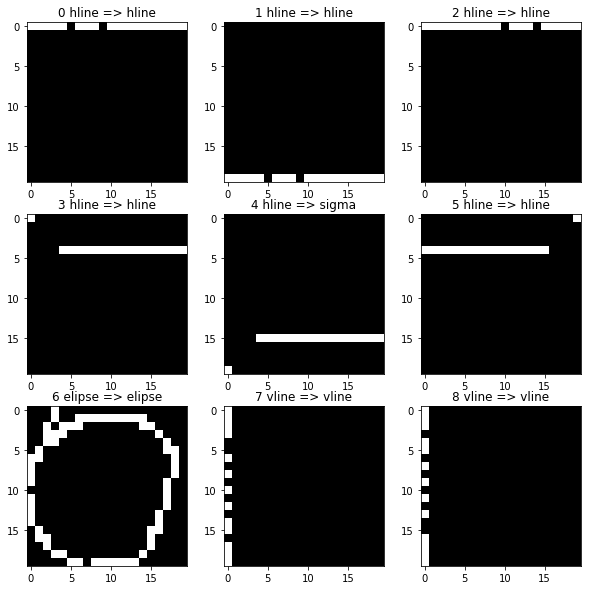

In [13]:
def show_plot(indices):
    plt.figure(figsize=(10,10))
    for p,i in enumerate(indices[:9]):
        plt.subplot(3,3,p+1)
        plt.imshow(X[i].reshape(img_size,img_size), cmap='gray', interpolation='none')
        plt.title("{} {} => {}".format(i,yLabel[i],predictedLabels[i]))

show_plot(range(9))

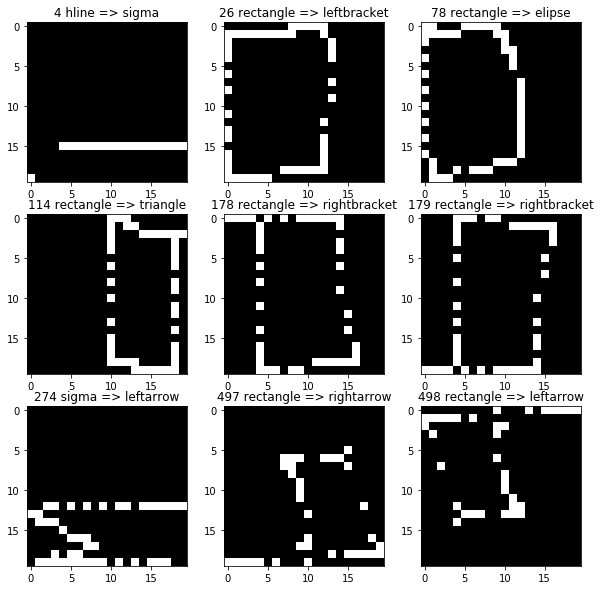

In [14]:
indices=[i for i,good in enumerate(predictedLabels==yLabel) if not good]
show_plot(indices)

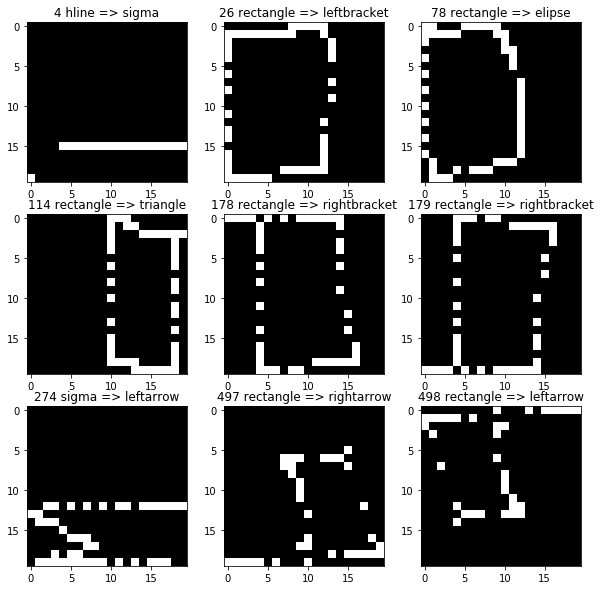

In [15]:
indices=[i for i,good in enumerate(predictedLabels==yLabel) if not good]
show_plot(indices)

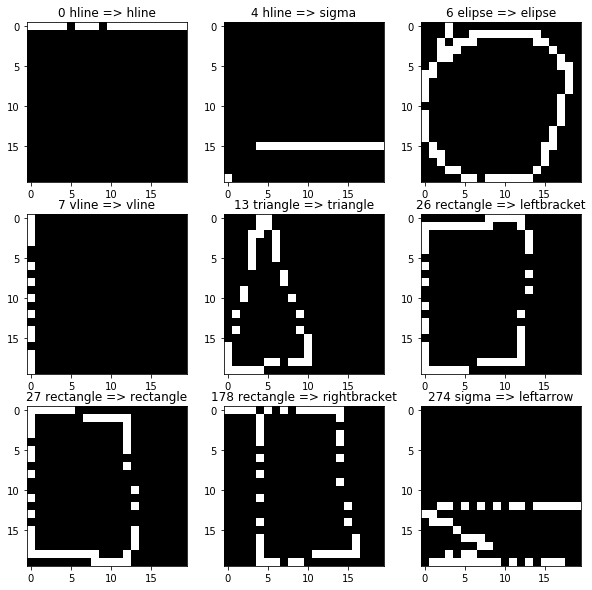

In [16]:
indices=[]
foundclasses=set(predictedLabels)
for i,c in enumerate(predictedLabels):
    if c in foundclasses:
        indices.append(i)
        foundclasses.remove(c)

show_plot(indices)

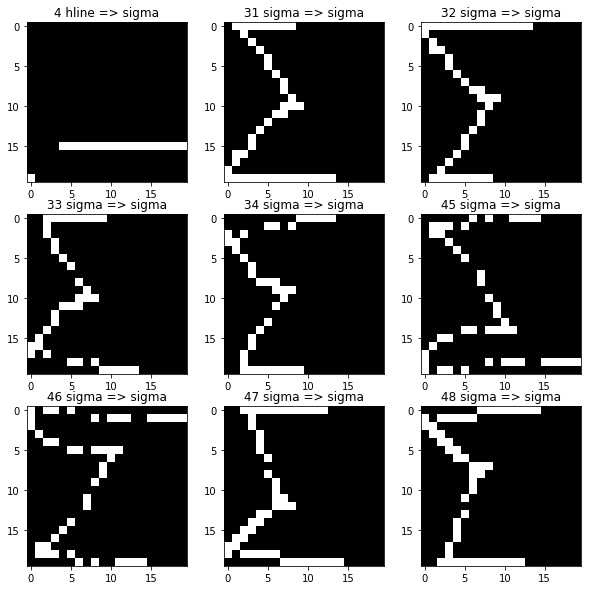

In [17]:
indices=[i for i,good in enumerate(predictedLabels=="sigma") if good]
show_plot(indices)

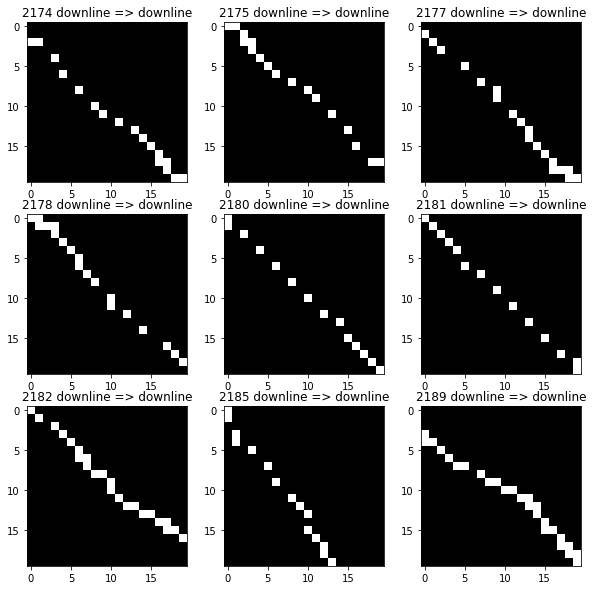

In [18]:
indices=[i for i,label in enumerate(yLabel) if label=="downline"]
show_plot(indices)

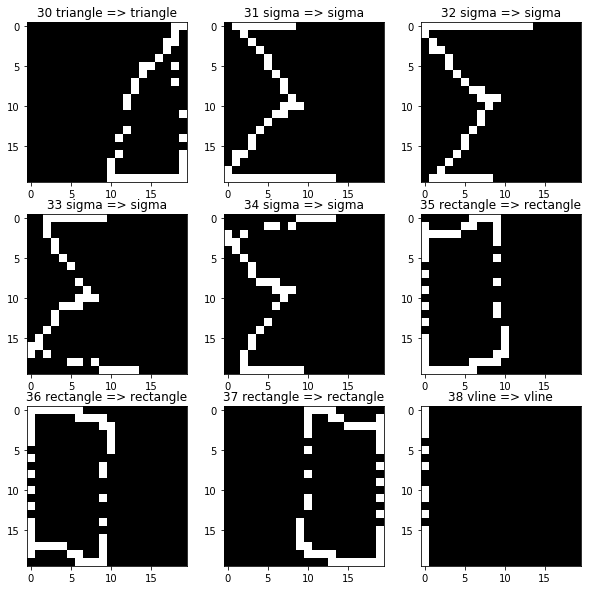

In [19]:
start=30
indices=range(start,start+9)
show_plot(indices)